# This JN has only one fluxonium qubit with its resonator and their corresponding simulations

After extracting the EJ and EL parameters, we return to this JN to run the EPR analysis again.

This notebook prepared by Figen Yilmaz

### Preparations

In [1]:
# For convenience, let's begin by enabling
# automatic reloading of modules when they change.
%load_ext autoreload
%autoreload 2
#%matplotlib inline

import numpy as np
from collections import OrderedDict

import warnings
warnings.filterwarnings('ignore')

import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict
import matplotlib.pyplot as plt

from qiskit_metal.toolbox_metal import math_and_overrides

from qiskit_metal.qlibrary.core import QComponent

from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.tlines.pathfinder import RoutePathfinder
from qiskit_metal.qlibrary.tlines.anchored_path import RouteAnchors

from qiskit_metal.qlibrary.qubits.fluxonium import FluxoniumPocket

from qiskit_metal.qlibrary.terminations.launchpad_wb import LaunchpadWirebond

from qiskit_metal.qlibrary.terminations.open_to_ground_v2 import OpenToGround
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer

import pyEPR as epr
from qiskit_metal.analyses.quantization import EPRanalysis

In [2]:
# Each time you create a new quantum circuit design,
# you start by instantiating a QDesign class.

# The design class `DesignPlanar` is best for 2D circuit designs.
design = designs.DesignPlanar()
design.chips.main.material = 'silicon'  # our substrate is Silicon
# cpw_width and cpw_gap is defined from the beginnning if you need you can 
# change it later. But with this way one can be sure all the lines are having same width and gap.
design.variables['cpw_width'] = '15 um'  
design.variables['cpw_gap'] = '8.733 um'  
design._chips['main']['size']['size_x'] = '9mm'  # Our device size is 9*9mm
design._chips['main']['size']['size_y'] = '9mm'
design._chips['main']['size']['size_z'] = '-525um' #Our wafer thicknes is 525 um +/-10

# If you disable the next line with "overwrite_enabled", then you will need to
# delete a component [<component>.delete()] before recreating it.
design.overwrite_enabled = True

eig_qres = EPRanalysis(design, "hfss")
hfss = design.renderers.hfss
hfss = eig_qres.sim.renderer
q3d = design.renderers.q3d

# run the GUI 
gui = MetalGUI(design)

In [3]:
from qiskit_metal.qlibrary.qubits.fluxonium import FluxoniumPocket

gds_cell_name_jj = 'junction_0'
gds_cell_name_inductor = 'jj_array0'

## fock=30, passes=18 
L_j = '40.58nH' # EJ/2pi = 4.02493 GHz
l_inductance = '216.0nH' ## from the analysis EL/2pi= 0.7561 GHz
C_j = '0.72fF' ## Calculated for 120*120 nm^2 area of the single JJ

options = dict(chip='main', nanowire = False, 
            orientation =90, pos_x = '-2.2mm', pos_y = '-2.3mm',
            gds_cell_name=gds_cell_name_jj, jj_width='10um',
            gds_cell_inductor=gds_cell_name_inductor ,
           L_j=L_j, C_j=C_j,
               l_inductance=l_inductance, 
               inductor_orientation='-1',
               
    flux_bias_line_options=Dict(make_fbl = True,
           ), 
               
    charge_line_options=Dict(loc_H = +1, make_cl = True,
                            ),
    readout_line_options=Dict(loc_H = -1, make_rol = True, 
              ) )
               
q1 = FluxoniumPocket(design,'Q1', options = dict(
             **options))

gui.rebuild()

In [4]:
# Lambda/2 resonators - Resonator1
otg1 = OpenToGround(design, 'otg1s', options=dict(chip='main', 
                 pos_x='-37.733um', pos_y='-2.8mm', orientation='270'))
rt_meander = RouteMeander(design, 'cavity1',  Dict(meander=Dict(spacing='200um'),
        # total_length='7.4mm', # fabricated value
        total_length='7.903mm', # this is to match the measured frequency for the following simulations
        hfss_wire_bonds = True,
        fillet='99um',
        lead = dict(start_straight='250um'),
        pin_inputs=Dict(
            start_pin=Dict(component='otg1s', pin='open'),
            end_pin=Dict(component='Q1', pin='readout_line')), ))

gui.rebuild()

In [5]:
q1 #print Q1 information

name:    Q1
class:   FluxoniumPocket       
options: 
  'pos_x'             : '-2.2mm',                     
  'pos_y'             : '-2.3mm',                     
  'orientation'       : 90,                           
  'chip'              : 'main',                       
  'layer'             : '1',                          
  'connection_pads'   : {
                        },
  'pad_gap'           : '30um',                       
  'jj_width'          : '10um',                       
  'jj_orientation'    : '1',                          
  'pad_width'         : '15um',                       
  'pad_height'        : '100um',                      
  'pad_radius'        : '60um',                       
  'l_width'           : '1um',                        
  'array_length'      : '130um',                      
  'l_arm_width'       : '2um',                        
  'l_arm_length'      : '20um',                       
  'l_inductance'      : '216.0nH',                    
  'L_j'      

In [6]:
# #Save screenshot as a .png formatted file.
# gui.screenshot()

### FX EPR starts after this cell

In [5]:
eig_qb = EPRanalysis(design,"hfss")

In [11]:
# Let's set all the variables, modes and passes here.

eig_qb.sim.setup_update(n_modes = 2,
                        max_delta_f = 0.1,
                        min_freq_ghz = 1,
                        max_passes = 18)

eig_qb.sim.setup.vars.Lj = q1.options.L_j  ## from the analysis Ej/2pi=4.02493 GHz
eig_qb.sim.setup.vars.Ls = q1.options.l_inductance ## from the analysis EL=0.7561 GHz
eig_qb.sim.setup.vars.Cj = q1.options.C_j ## from the calculations C_j = 0.72 fF

eig_qb.sim.setup


{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'min_freq_ghz': 1,
 'n_modes': 2,
 'max_delta_f': 0.1,
 'max_passes': 18,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '40.58nH', 'Cj': '0.72fF', 'Ls': '216.0nH'}}

In [12]:
qubit_nr = '1' # define your qubit number here, then it will take the same number for the cavity and the open_terminals
eig_qb.sim.run(name="FluxoniumEPR", components=['Q'+qubit_nr, 'cavity'+qubit_nr, 'otg'+qubit_nr+'s'], 
               open_terminations=[], box_plus_buffer = True)

INFO 03:37PM [connect_project]: Connecting to Ansys Desktop API...
INFO 03:37PM [load_ansys_project]: 	Opened Ansys App
INFO 03:37PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 03:37PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/figenyilmaz/Documents/Ansoft/
	Project:   Project86
INFO 03:37PM [connect_design]: No active design found (or error getting active design).
INFO 03:37PM [connect]: 	 Connected to project "Project86". No design detected
INFO 03:37PM [connect_design]: 	Opened active design
	Design:    FluxoniumEPR_hfss [Solution type: Eigenmode]
WARNING 03:37PM [connect_setup]: 	No design setup detected.
WARNING 03:37PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:37PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 03:37PM [analyze]: Analyzing setup Setup
04:28PM 29s INFO [get_f_convergence]: Saved convergences to C:

In [13]:
eig_qb.sim.convergence_f

,re(Mode(1)) [g],re(Mode(2)) [g]
Pass [],,
1,3.325465,4.224529
2,4.280044,5.042277
3,4.979853,5.637435
4,5.359276,6.127715
5,5.523984,6.389086
6,5.635749,6.515291
7,5.706230,6.584543
8,5.745003,6.613172
9,5.771685,6.636791


In [14]:
# Add the geometry of the rectangle  and line of the inductor to the list of junctions
eig_qb.setup.junctions.jj.rect = 'JJ_rect_Lj_Q'+qubit_nr+'_rect_jj'
eig_qb.setup.junctions.jj.line = 'JJ_Lj_Q'+qubit_nr+'_rect_jj_'

eig_qb.add_junction(name_junction ='inductor')
eig_qb.setup.junctions.inductor.Lj_variable = 'Ls'
eig_qb.setup.junctions.inductor.rect = 'JJ_rect_Lj_Q'+qubit_nr+'_inductor'
eig_qb.setup.junctions.inductor.line = 'JJ_Lj_Q'+qubit_nr+'_inductor_'
eig_qb.setup.junctions.inductor.is_junction = False

# Set up the EPR analysis parameters
eig_qb.setup.fock_trunc = 30 # you may use 20 as well
eig_qb.setup.cos_trunc = 6

eig_qb.setup.flux = 0.0

eig_qb.setup.basis = 'HO'

# eig_qb.setup.sweep_variable = 'flux'   #--- This would be nice to implement to get a sweep over flux bias 
eig_qb.setup

{'junctions': {'jj': {'Lj_variable': 'Lj',
   'Cj_variable': 'Cj',
   'rect': 'JJ_rect_Lj_Q1_rect_jj',
   'line': 'JJ_Lj_Q1_rect_jj_'},
  'inductor': {'Lj_variable': 'Ls',
   'Cj_variable': 'Cj',
   'rect': 'JJ_rect_Lj_Q1_inductor',
   'line': 'JJ_Lj_Q1_inductor_',
   'is_junction': False}},
 'dissipatives': {'dielectrics_bulk': ['main']},
 'cos_trunc': 6,
 'fock_trunc': 30,
 'flux': 0.0,
 'basis': 'HO',
 'sweep_variable': 'Lj'}

In [15]:
# eig_qb.run_epr()
#### equivalent individual calls
s = eig_qb.setup
eig_qb.epr_start()
eig_qb.get_stored_energy()
eig_qb.run_analysis()

Design "FluxoniumEPR_hfss" info:
	# eigenmodes    2
	# variations    1
Design "FluxoniumEPR_hfss" info:
	# eigenmodes    2
	# variations    1
Design "FluxoniumEPR_hfss" info:
	# eigenmodes    2
	# variations    1

        energy_elec_all       = 5.85396737552601e-26
        energy_elec_substrate = 5.39419520700215e-26
        EPR of substrate = 92.1%

        energy_mag    = 5.22270369103284e-28
        energy_mag % of energy_elec_all  = 0.9%
        

Variation 0  [1/1]

  Mode 0 at 5.86 GHz   [1/2]
    Calculating ℰ_magnetic,ℰ_electric
       (ℰ_E-ℰ_H)/ℰ_E       ℰ_E       ℰ_H
               99.1%  2.927e-26 2.611e-28

    Calculating junction energy participation ration (EPR)
	method=`line_voltage`. First estimates:
	junction        EPR p_0j   sign s_0j    (p_capacitive)
		Energy fraction (Lj over Lj&Cj)= 90.08%
	jj              0.862743  (+)        0.095003
		Energy fraction (Lj over Lj&Cj)= 63.05%
	inductor        0.162246  (+)        0.0950983
		(U_tot_cap-U_tot_ind)/mean=7.02%
Ca

In [16]:
import os; os.getcwd()

'C:\\Users\\figenyilmaz\\Desktop\\GitLab\\data-analysis-epr-project'

In [18]:
eig_qb.spectrum_analysis(s.cos_trunc, s.fock_trunc, basis=s.basis, flux=s.flux, junctions=[0])
eig_qb.report_hamiltonian(s.sweep_variable)

WARNING 05:04PM [__init__]: <p>Error: <class 'IndexError'></p>


	 Differences in variations:



 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Variation 0

[4.058e-08 2.160e-07]
[0]
Using Full Cosine Potential
ϕzpf mode 0 :  0.7794775837208632
ϕzpf mode 1 :  -0.054605663773885725
Starting the diagonalization
Finished the diagonalization
(2, 1)
Single junctions -- assuming single qubit mode
The biggest elements in the fidelity list are:
Element: 0.9999392482782846, Index: 0
Element: 0.9983036079859345, Index: 1
Element: 0.9920372563433962, Index: 3
Element: 0.9771496697352123, Index: 4
Element: 0.9647850547304123, Index: 6
Element: 0.9712013015410212, Index: 8
Element: 0.9688499515757001, Index: 10
Element: 0.9650989918349899, Index: 12
Element: 0.8428895564469315, Index: 17
Element: 0.9596258027971842, Index: 20
Element: 0.95692606319231, Index: 25
Element: 0.9537471797055533, Index: 29
Element: 0.9499505095343461, Index: 34
Element: 0.9446412258076144, Index: 42
Element: 0.9378150603322714, Index: 49
Element: 0.9

#### Mode frequencies (MHz)

###### Numerical diagonalization

OrderedDict([(40.58,
              0     5002.97
              1     6668.31
              2        0.00
              3     5002.97
              4     8852.97
              5    10923.09
              6    12005.44
              dtype: float64)])

#### Kerr Non-linear coefficient table (MHz)

###### Numerical diagonalization

0         1
Lj                        
40.58 0  1152.97  2.31e+00
      1     2.31  8.85e-04

# Q1 and Res 1 

In [26]:
from IPython.display import clear_output
chis = []
freq_q = []
freq_r = []
phis = np.linspace(-0.06,0.6,501)
for phi in phis:
    eig_qb.setup.flux = phi
    s = eig_qb.setup
    eig_qb.spectrum_analysis(s.cos_trunc, s.fock_trunc, basis=s.basis, flux=s.flux, junctions=[0])
    a = eig_qb.sim.renderer.epr_quantum_analysis.get_frequencies()
    freq_r.append(a['0'][1])
    freq_q.append(a['0'][0])
    b = eig_qb.sim.renderer.epr_quantum_analysis.get_chis()
    chi = -b[0][1]
    chis.append(chi)
    clear_output()

In [27]:
with open('EPR_simulations_data.npy', 'wb') as f:
    np.save(f, chis)
    np.save(f, np.array(freq_q)/1000)
    np.save(f, np.array(freq_r)/1000)
    np.save(f, phis)

In [28]:
%matplotlib inline

In [29]:
plt.show()

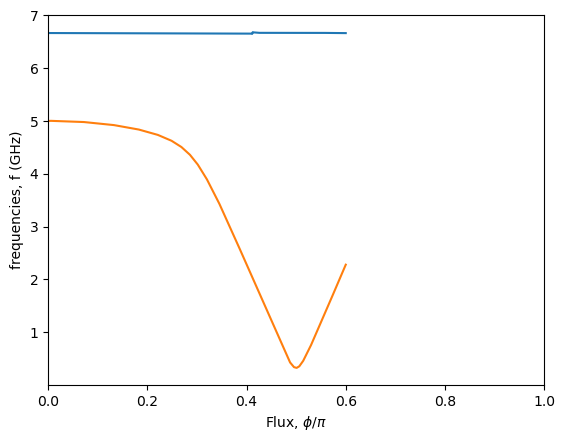

In [30]:
plt.plot(phis,np.array(freq_r)/1000)
plt.plot(phis,np.array(freq_q)/1000)
plt.xlabel(r'Flux, $\phi/\pi$')
plt.ylabel('frequencies, f (GHz)')
plt.xlim(0,1)
#plt.ylim(0.19,2.075)
#plt.show()
plt.savefig('EPR_QubitandRes_freq.png', dpi=200)

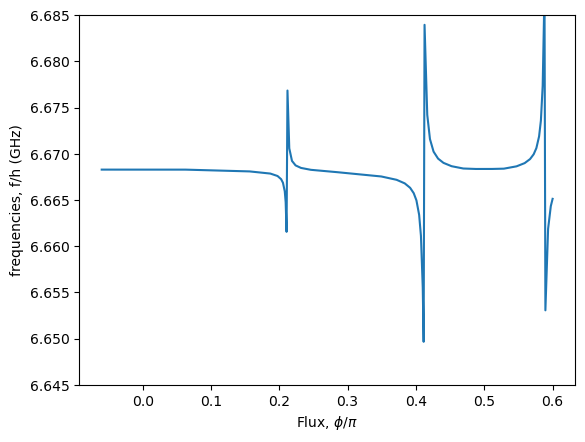

In [31]:
plt.plot(phis,np.array(freq_r)/1000)
#plt.plot(phis,np.array(freq_q)/1000)
plt.xlabel(r'Flux, $\phi/\pi$')
plt.ylabel('frequencies, f/h (GHz)')
plt.ylim(6.645,6.685)
plt.savefig('EPR_Res_freq.png', dpi=200)

## Now, it is time to fix the resonator dressed frequency to the measurement freq

In [106]:
from qiskit_metal.renderers.renderer_ansys.ansys_renderer import QAnsysRenderer
QAnsysRenderer.default_options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.2,
 'y_buffer_width_mm': 0.2,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [112]:
# Run this cell if ANSYS is already is not open
hfss.open_ansys()

In [11]:
# Be sure the software is totally open and ready to connect
hfss.connect_ansys()

INFO 02:54PM [connect_project]: Connecting to Ansys Desktop API...
INFO 02:54PM [load_ansys_project]: 	Opened Ansys App
INFO 02:54PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 02:54PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/figenyilmaz/Documents/Ansoft/
	Project:   Project63
INFO 02:54PM [connect_design]: No active design found (or error getting active design).
INFO 02:54PM [connect]: 	 Connected to project "Project63". No design detected


In [12]:
# here, just open a new project with a desired name. 
# FYI: if you need to render the same element then, change the project name
hfss.activate_eigenmode_design("cavity1")

02:54PM 36s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
02:54PM 36s WARNING [activate_ansys_design]: The design_name=cavity1 was not in active project.  Designs in active project are: 
[].  A new design will be added to the project.  
INFO 02:54PM [connect_design]: 	Opened active design
	Design:    cavity1 [Solution type: Eigenmode]
WARNING 02:54PM [connect_setup]: 	No design setup detected.
WARNING 02:54PM [connect_setup]: 	Creating eigenmode default setup.
INFO 02:54PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [13]:
hfss.render_design(['cavity1'], [('cavity1', 'end'), ('cavity1', 'start')])

In [14]:
# Analysis properties
setup = hfss.pinfo.setup
setup.passes = 15
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '40.7886 nH')
pinfo.design.set_variable('Cj', '0.72 fF')
setup.analyze()

hfss.plot_convergences()

INFO 02:56PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 1
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:07PM 03s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


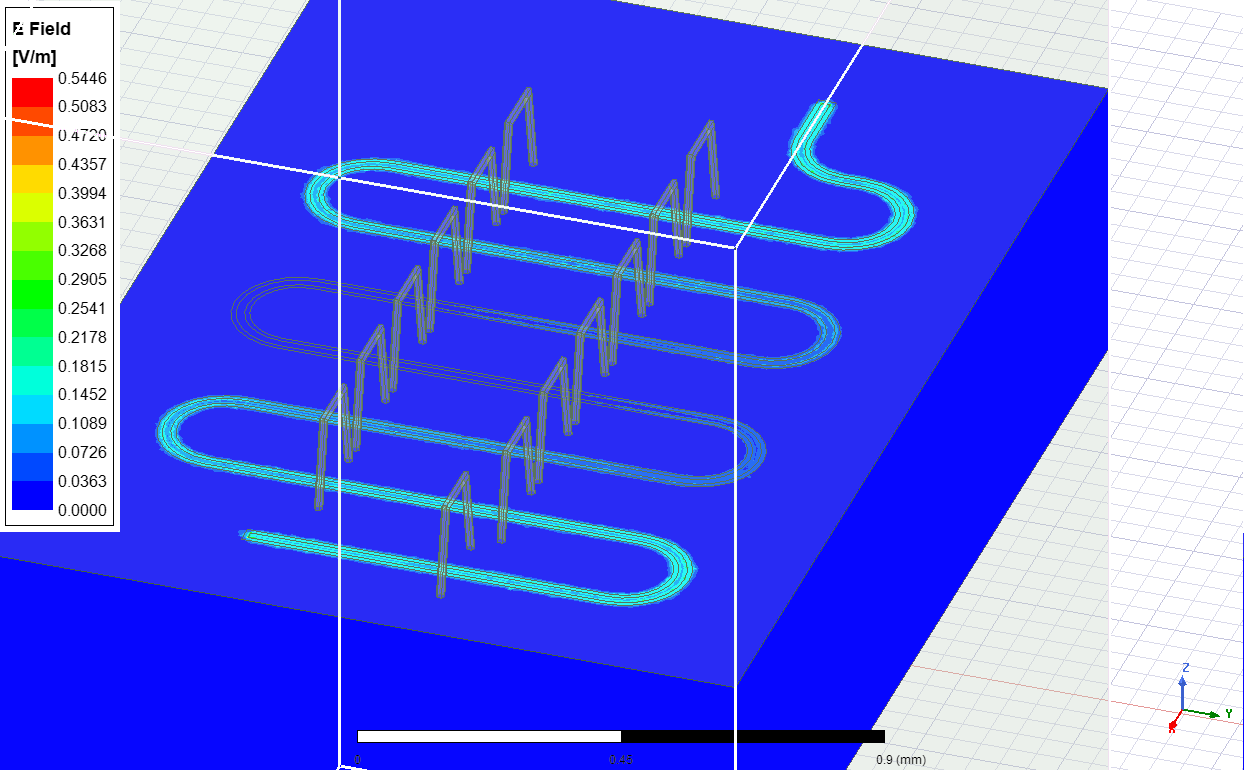

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/data-analysis-epr-project/ansys.png')

In [15]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [16]:
hfss.epr_get_frequencies()

Design "cavity1" info:
	# eigenmodes    1
	# variations    1


,,Freq. (GHz),Quality Factor
variation,mode,,
0,0,7.503493,inf


## Here, we couple the resonator to the qubit to get dressed frequency

In [17]:
# same as before, open a new project
hfss.activate_eigenmode_design("Q1_Res1")

03:07PM 23s WARNING [activate_eigenmode_design]: This method is deprecated. Change your scripts to use activate_ansys_design()
03:07PM 23s WARNING [activate_ansys_design]: The design_name=Q1_Res1 was not in active project.  Designs in active project are: 
['cavity1'].  A new design will be added to the project.  
INFO 03:07PM [connect_design]: 	Opened active design
	Design:    Q1_Res1 [Solution type: Eigenmode]
WARNING 03:07PM [connect_setup]: 	No design setup detected.
WARNING 03:07PM [connect_setup]: 	Creating eigenmode default setup.
INFO 03:07PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


In [18]:
# here, one can create a box around your elements. 
# This part can be effective during the simulations
hfss.options['x_buffer_width_mm'] = 0.9 # remember: our device size is 9*9mm
hfss.options['y_buffer_width_mm'] = 0.9 # FYI: 0.5 also fine to use
hfss.options

{'Lj': '10nH',
 'Cj': 0,
 '_Rj': 0,
 'max_mesh_length_jj': '7um',
 'project_path': None,
 'project_name': None,
 'design_name': None,
 'x_buffer_width_mm': 0.9,
 'y_buffer_width_mm': 0.9,
 'wb_threshold': '400um',
 'wb_offset': '0um',
 'wb_size': 5,
 'plot_ansys_fields_options': {'name': 'NAME:Mag_E1',
  'UserSpecifyName': '0',
  'UserSpecifyFolder': '0',
  'QuantityName': 'Mag_E',
  'PlotFolder': 'E Field',
  'StreamlinePlot': 'False',
  'AdjacentSidePlot': 'False',
  'FullModelPlot': 'False',
  'IntrinsicVar': "Phase='0deg'",
  'PlotGeomInfo_0': '1',
  'PlotGeomInfo_1': 'Surface',
  'PlotGeomInfo_2': 'FacesList',
  'PlotGeomInfo_3': '1'}}

In [19]:
# here, one needs to render qubit and the resonator
hfss.render_design(['Q1', 'cavity1', 'otg1s'],[('cavity1', 'end')])

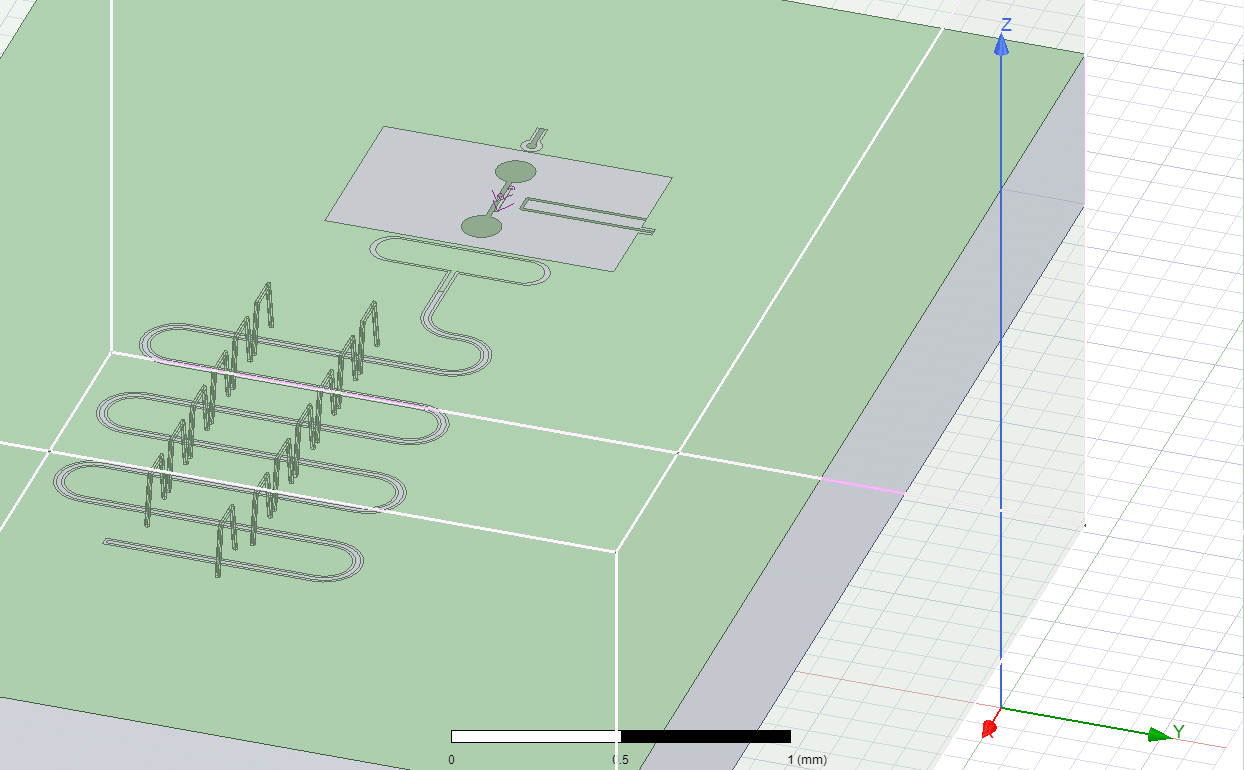

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/data-analysis-epr-project/ansys.png')

In [20]:
# a screenshot can be lovely here
hfss.save_screenshot()

In [21]:
# Analysis properties
setup = hfss.pinfo.setup
setup.n_modes = 2
setup.passes = 15
#setup.delta_f = 0.05
print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

pinfo = hfss.pinfo
pinfo.design.set_variable('Lj', '40.7532 nH')
pinfo.design.set_variable('Cj', '0 fF')
setup.analyze()

hfss.plot_convergences()

INFO 03:08PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 2
Number of simulation passes              = 15
Convergence freq max delta percent diff  = 0.1

This method is deprecated. Change your scripts to use the equivalent method plot_convergence() that has been moved inside the EPRanalysis class.


03:33PM 02s WARNING [plot_ansys_fields]: This method is deprecated. Change your scripts to use plot_fields()


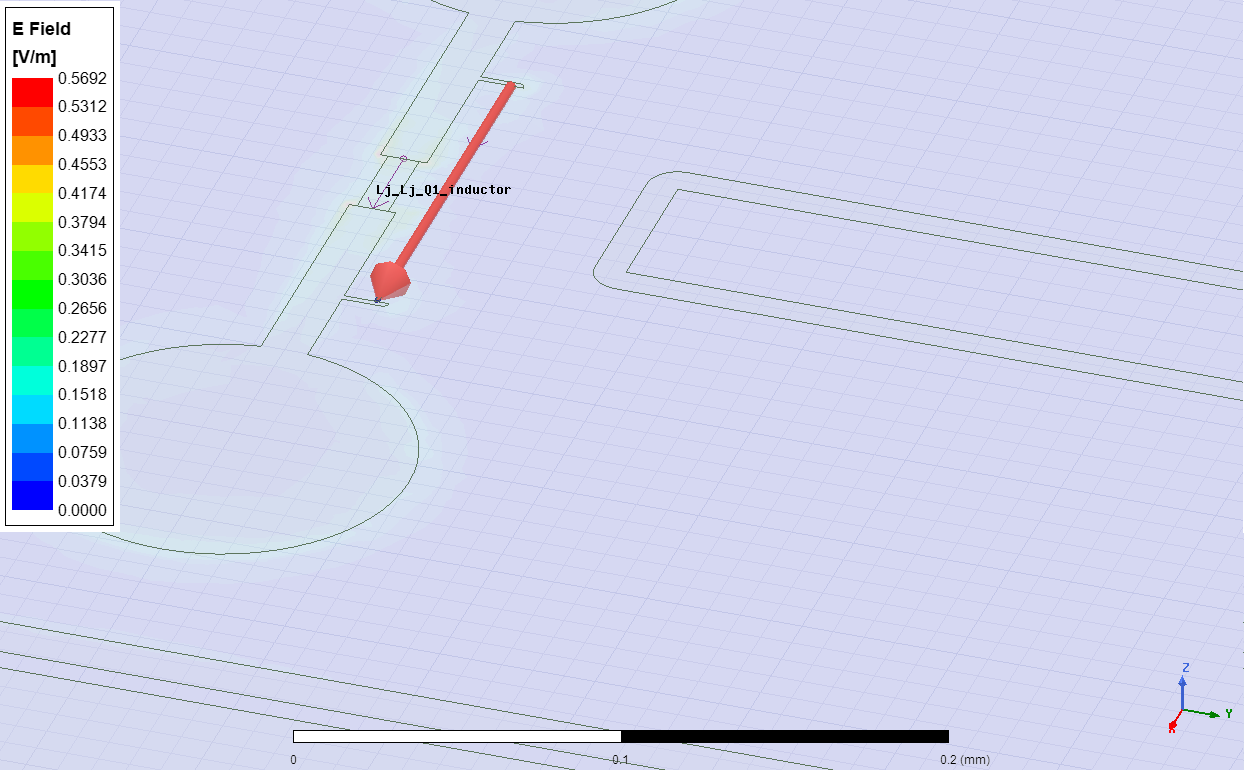

WindowsPath('C:/Users/figenyilmaz/Desktop/GitLab/data-analysis-epr-project/ansys.png')

In [22]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_ansys_fields('main')
hfss.save_screenshot()

In [23]:
hfss.plot_ansys_delete(['Mag_E1'])

04:03PM 32s WARNING [plot_ansys_delete]: This method is deprecated. Change your scripts to use clear_fields()


In [24]:
hfss.epr_get_frequencies()

Design "Q1_Res1" info:
	# eigenmodes    2
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.801528             inf
          1        6.673297             inf

## Calculate the coupling strenght, g and EC

In [6]:
# For getting the Maxwell Capacitance Matrix we use LOM analysis but not all of it
from qiskit_metal.analyses.quantization import LOManalysis

c1 = LOManalysis(design, "q3d")
c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': True,
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [7]:
# Before this cell, one needs to have the elements on the GUI
c1.sim.setup.max_passes = 20
# example: update multiple settings
c1.sim.setup_update(solution_order = 'High', auto_increase_solution_order = 'False')

c1.sim.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5.0,
 'save_fields': False,
 'enabled': True,
 'max_passes': 15,
 'min_passes': 2,
 'min_converged_passes': 2,
 'percent_error': 0.5,
 'percent_refinement': 30,
 'auto_increase_solution_order': 'False',
 'solution_order': 'High',
 'solver_type': 'Iterative'}

In [8]:
c1.sim.run(components=['Q1','cavity1', 'otg1s'],box_plus_buffer=False,
           open_terminations=[('Q1', 'charge_line'), ('Q1', 'flux_bias_line'), ('Q1', 'fake_flux_bias_line'),
               ('cavity1', 'end'), ('cavity1', 'start')])
c1.sim.capacitance_matrix

INFO 01:56PM [connect_project]: Connecting to Ansys Desktop API...
INFO 01:56PM [load_ansys_project]: 	Opened Ansys App
INFO 01:56PM [load_ansys_project]: 	Opened Ansys Desktop v2020.2.0
INFO 01:56PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/figenyilmaz/Documents/Ansoft/
	Project:   Project87
INFO 01:56PM [connect_design]: No active design found (or error getting active design).
INFO 01:56PM [connect]: 	 Connected to project "Project87". No design detected
INFO 01:56PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
WARNING 01:56PM [connect_setup]: 	No design setup detected.
WARNING 01:56PM [connect_setup]: 	Creating Q3D default setup.
INFO 01:56PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:57PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 01:57PM [analyze]: Analyzing setup Setup
INFO 02:10PM [get_matrix]: Exporting matrix data to (C:\Users\FIGENY~1\AppDat

,charge_line_Q1,flux_bias_line_Q1,g_wb,pad_bot_Q1,pad_top_Q1,readout_padNline_Q1
charge_line_Q1,22.17790,-0.12288,-21.26137,-0.06165,-0.60499,-0.04580
flux_bias_line_Q1,-0.12288,59.01259,-45.95352,-4.73562,-4.75555,-2.28282
g_wb,-21.26137,-45.95352,1701.55581,-22.39741,-26.18634,-1481.02493
pad_bot_Q1,-0.06165,-4.73562,-22.39741,36.89709,-3.46150,-5.57596
pad_top_Q1,-0.60499,-4.75555,-26.18634,-3.46150,36.83956,-1.06220
readout_padNline_Q1,-0.04580,-2.28282,-1481.02493,-5.57596,-1.06220,1493.74292


In [12]:
# Calcute the Total Capacitance and Charging Energy
import numpy as np
import math
from math import *
from collections import OrderedDict

import scipy
import scipy.optimize as opt
from scipy import constants
import matplotlib.pyplot as plt

e = 1.60217663e-19
hbar = 1.05457182e-34

#Units are in femto Farad
Cpadtop_ground = 26.217e-15  ## C1 value
Cpadbot_ground = 22.423e-15  ## C2 value
Creadout_bot = 5.5904e-15 ## readout pad to pad bottom
Creadout_top = 1.06731e-15  ## readout pad to pad top
Ccharge_top = 0.6066e-15  ## charge line to pad top
Cfluxpad_top = 4.76484e-15  ## flux_bias line to pad top
Cfluxpad_bot = 4.7431e-15  ## flux_bias line to pad bottom

C_pads = 3.465e-15 ## capacitance between top pad to bottom pad, 
C_j = 0.72e-15 # calculated value, details explained in the paper

C_top = Cpadtop_ground + Ccharge_top + Cfluxpad_top + Creadout_top
C_bot = Cpadbot_ground + Cfluxpad_bot + Creadout_bot

Cstar = C_j + C_pads + C_top*C_bot/(C_top+C_bot)

Ec = e**2/(2*Cstar)
Charging_energy = 1e-6*Ec/(2*np.pi*hbar)

print('Ctop:', C_top, 'fF')
print('Cbot:', C_bot, 'fF')
print('Total Capacitance:', Cstar, 'fF')
print('Charging Energy:', Charging_energy, 'MHz')

Ctop: 3.2655750000000005e-14 fF
Cbot: 3.27565e-14 fF
Total Capacitance: 2.0538023705422153e-14 fF
Charging Energy: 943.1398786237952 MHz


## Calculate the coupling stregth g

In [27]:
Cpad=177.12e-15
Z_0=50
A = omega_r1*Cpad*Z_0

print(A)

C_approx = np.cos(A)
C_approx

119889591.55100147
0.3715453761675295


0.931767400672063

In [28]:
# calculate g
f_r1 = 6.6772e9 # Hz, Dressed freq
omega_r1 = 2*pi*f_r1 # angular resonator freq of a lambda/2 resonator
Cqr = Creadout_bot - Creadout_top  # unit femtoFarad, readout pad to pad_bot and pad_top
B = Cqr/Cstar*C_top/(C_bot+C_top)

g = 2*e*B*omega_r1*math.sqrt(Z_0/(hbar*pi))*C_approx # radyan
print(Cqr)
print('Cstar:', Cstar)
print('g:', g/2/pi*1e-6, 'MHz')

4.52309e-15
Cstar: 2.0538023705422153e-14
g: 85.15132750853999 MHz


In [66]:
hfss.disconnect_ansys()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


In [67]:
gui.main_window.close()

True